In [1]:
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt

In [2]:
nltk.download('stopwords')
nltk.download('words')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## 1. Hashing

### Hash Function Implementation

In [3]:
import random

Our hash function will be determined by random integer coefficients quantity of which will correspond to the length of the string. The range of these random integers will be from 0 to 2 to the power of length of the string. In our case the strigth lenght is 32. So, there will be 32 random integer coefficients from 0 to 2^32. Example is in the cell below.  

Secondly, the unicode order of each letter in the string will be multipled by the corresponding random coefficient in the list. 

Thirdly, these multiplication will be summed. 

Finally, (this sum) mod 2^(2 to the power of length of the string)

In [4]:
# example of random sample
cf = random.sample(range(0, 2**32), 32)
print(cf)

[1026905847, 2103188196, 3651828109, 115748938, 2494444012, 1342723750, 1049179202, 1054554012, 3320362845, 1680948439, 3088084463, 113589989, 3664238750, 1111024846, 2484166602, 769273226, 3900564355, 374892456, 1220797236, 2562635685, 1996043166, 257312252, 1303026960, 2321696179, 3396349590, 2545161103, 314034416, 58366370, 793513433, 1237777291, 1794400204, 3977620760]


In [5]:
def hashing(string):
    cf = random.sample(range(0, 2**len(string)), len(string))
    summation = 0
    for i in range(0,len(string)):
        summation = summation + cf[i]*ord(string[i])    
    return summation % (2**len(string))

In [6]:
# example of the implementation of hash function
hashing('b66f73ffd9008d9c99159e164261df51')

2582139911

In [7]:
def hashing_cf(string, cf):
    summation = 0
    for i in range(0,32):
        summation = summation + cf[i]*ord(string[i])    
    return summation % (2**32)

### Implementation of hash function algorithm called HyperLogLog (HLL)

#### But, first, let's create necessary functions for our analysis.

The function below gives the position of the leftmost 1

In [8]:
def leftmost1 (string):
    return len(string)- string.rfind('1') - 1

In [9]:
# e.g.
leftmost1 ('0100')

2

This function changes numbers to their 32-bit bin form

In [10]:
def conversion32(num):
     return bin(num)[2:].zfill(32)

In [11]:
# e.g.
conversion32(1997)

'00000000000000000000011111001101'

This function creates two numbers: the first consists of the first 6 figures and the second contains the rest

In [12]:
def splitting (string):
    return int('0b' + string[:6], 2), string[6:]

In [13]:
# e.g
splitting ('1010010110110')

(41, '0110110')

By using all relevant functions created above, this function is responsible for creation of the buckets of a 6-bit hyperLogLog structure

In [14]:
def hyperlglg_function (data, cf):
    
    buckets = [0]*2**6
    for x in data[0]: 
        h_value = hashing_cf(x, cf)    # implementing our previously created functions
        bin_h_value = conversion32(h_value)  
        name_buck, hash_buck = splitting (bin_h_value)  
        
        buckets[name_buck] = max(buckets[name_buck], leftmost1(hash_buck))  # Here we are simply updating the buckets 
                                                                            #  with the highest count of zeroes
    return buckets


Given a set of buckets of hyperLogLog structure, this function tries to give estimate of its cardinality

In [15]:
def hyperlglg_cardinality (buckets):
    total = 0 
    for i in buckets:
        total = total + pow(2, -i)
    return (2*0.709) *(len(buckets)**2)/total 

#### Now, Implementation of HyperLogLog

Since we are going to implement 6bitsHyperLogLog, the first 6 bits of the binary representation of the hash value are going to be assigned a bucket number. 

In [16]:
dataset = pd.read_csv('hash.txt', nrows=100000, header=None)
dataset.head()

,0
0,844082e02a27ddee8d99ea1af94a2969
1,ff96d6665b5c59d3a70bb8f2ba4f10be
2,b64a85884e2b159829331c19e05dbac9
3,1c8836719e84867c26ba2cfeb372c53d
4,b66f73ffd9008d9c99159e164261df51


In [17]:
b = hyperlglg_function(dataset, cf)

In [18]:
hyperlglg_cardinality(b) #the error of the filter

112782.6597357037

## 2. Clustering


#### Let's firstly explore data. Here is information about data from Kaggle:
"This dataset consists of reviews of fine foods from amazon. The data span a period of more than 10 years, including all ~500,000 reviews up to October 2012. Reviews include product and user information, ratings, and a plain text review. It also includes reviews from all other Amazon categories"

List of columns (most are self-explanatory):
<br>
1)Id 
<br>
2) ProductId
<br>
2) UserId 
<br>
3) ProfileName (author username; sometimes it is absent)
<br>
4) HelpfulnessNumerator (quantity of users who found review beneficial)
<br>
5) HelpfulnessDenominator (quantiy of users that regarded the review as either helpful or not)
<br>
6) Score (score of the review product)
<br>
7) Time (timestamp of in UNIX format)
<br>
8) Summary (concise summary of review)
<br>
9) Text  (review plain text)

N.B. It is important to prepare and clean data because the k-means might suffer from high dimensionality. 

In [15]:
df = pd.read_csv('data/Reviews.csv') # we are decreasing amount of data due to computation time
df = df.drop_duplicates(subset='ProductId', keep="first")
df['ds']=df.Time.apply(lambda value:pd.to_datetime(value,unit='s'))
df.head(2)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...


In [18]:
df.isnull().sum()

Id                        0
ProductId                 0
UserId                    0
ProfileName               0
HelpfulnessNumerator      0
HelpfulnessDenominator    0
Score                     0
Time                      0
Summary                   0
Text                      0
ds                        0
dtype: int64

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74258 entries, 0 to 568453
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Id                      74258 non-null  int64         
 1   ProductId               74258 non-null  object        
 2   UserId                  74258 non-null  object        
 3   ProfileName             74258 non-null  object        
 4   HelpfulnessNumerator    74258 non-null  int64         
 5   HelpfulnessDenominator  74258 non-null  int64         
 6   Score                   74258 non-null  int64         
 7   Time                    74258 non-null  int64         
 8   Summary                 74258 non-null  object        
 9   Text                    74258 non-null  object        
 10  ds                      74258 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(5), object(5)
memory usage: 6.8+ MB


### The next point is to clean and prepare data for k-means algorithm

Almost every Natural Language Processing task requires text to be preprocessed before starting to work on it. So, this is what we are going to do first. 

In [3]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
import nltk

In [21]:
e_words = set(nltk.corpus.words.words())
#lemmatizer = WordNetLemmatizer()
stopwords = set(stopwords.words('english'))

In [4]:
def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in text]

In [23]:
len(e_words)

235892

In [5]:
def text_cleaning(text):
    tokenized_words = word_tokenize(text)
    cleaned_words = []
    for word in tokenized_words:
        if word.isalpha() and word.lower() not in stopwords and word.lower() in e_words:
            cleaned_words.append(word.lower())
    return cleaned_words

In [25]:
df['cleaned_text'] = df.Text.apply(text_cleaning)

In [26]:
df = df[['Id','ProductId','UserId','Score','cleaned_text', 'ds']]
df = df.rename(columns={"Id": "id", "ProductId": "pid", 'UserId': 'uid', 'cleaned_text':'ctext', 'Score':'score'})
df.head(2)

,id,pid,uid,score,ctext,ds
0,1,B001E4KFG0,A3SGXH7AUHU8GW,5,"[bought, several, vitality, canned, dog, food,...",2011-04-27
1,2,B00813GRG4,A1D87F6ZCVE5NK,1,"[product, jumbo, salted, actually, small, size...",2012-09-07


In [27]:
df.to_csv('cleaned_data1.csv', compression  = 'gzip') #saving the data in case of losing it

#### Further data cleaning

Here, we are using spacy to make some further data adjustments. We want to leave only nouns here. 

In [6]:
import spacy
nlp = spacy.load('en_core_web_sm')

def nouns_list(i):
    
    i = " ".join(i)

    member = nlp(i)
    nouns = []
    for token in member:
        if token.pos_ == 'NOUN':
            nouns.append(token)
    return nouns

Initially, I ran the code for almost three hours and it still ran. So, I was compelled to decrease the data based on product id. 

In [55]:
len(all_nouns) # this is a length of the previous list. It turns out it almost finished. 

522600

In the code below, I am reruning it. 

In [9]:
all_nouns = []
li = df['ctext'].tolist()
for i in li:
    nouns = nouns_list(i)
    all_nouns.append(nouns)

In [30]:
df['nouns'] = all_nouns
df.head(2)

,id,pid,uid,score,ctext,ds,nouns
0,1,B001E4KFG0,A3SGXH7AUHU8GW,5,"[bought, several, vitality, canned, dog, food,...",2011-04-27,"[vitality, dog, food, quality, product, meat, ..."
1,2,B00813GRG4,A1D87F6ZCVE5NK,1,"[product, jumbo, salted, actually, small, size...",2012-09-07,"[product, jumbo, error, vendor, represent, pro..."


In [31]:
df.to_csv('cleaned_data2.csv', compression  = 'gzip') ##saving the data in case of losing it again

In [10]:
df.to_csv('cleaned_data3.csv', compression  = 'gzip') ##saving the data in case of losing it again

In [102]:
df = pd.read_csv('cleaned_data3.csv', compression  = 'gzip')
df = df.drop(columns=['Unnamed: 0'])
df.head(2)

,id,pid,uid,score,ds,nouns
0,1,B001E4KFG0,A3SGXH7AUHU8GW,5,2011-04-27,"[vitality, dog, food, quality, product, meat, ..."
1,2,B00813GRG4,A1D87F6ZCVE5NK,1,2012-09-07,"[product, jumbo, error, vendor, represent, pro..."


In [13]:
pd.Series(df['nouns']).value_counts()[:20]

[]                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  423
[product]                                                                                                                                                                                       

As you can see, there are many words with just a general meaning. It is a good idea to erase some of them. 

In [103]:
redundant_words = ['product', 'flavor', 'taste', 'price', 'love', 'order', 'flavour', 'stuff', 'time', 'way', 'use', 'lot']

In [93]:
def further_cleaning(i):    
    
    i = "".join(i)
    i= i.replace("[", "")
    i= i.replace("]", "")
    i = list(i.split(',')) 
    
    upd_nouns = []
    for n in i:
        n = n.strip()
        
        if n not in redundant_words : 
            upd_nouns.append(n)
    return upd_nouns

In [104]:
updated_nouns = []
for i in df['nouns'].tolist(): 
    updated_nouns.append(further_cleaning(i))    

In [105]:
df["upd_nouns"] = updated_nouns
df.head(2)

,id,pid,uid,score,ds,nouns,upd_nouns
0,1,B001E4KFG0,A3SGXH7AUHU8GW,5,2011-04-27,"[vitality, dog, food, quality, product, meat, ...","[vitality, dog, food, quality, meat]"
1,2,B00813GRG4,A1D87F6ZCVE5NK,1,2012-09-07,"[product, jumbo, error, vendor, represent, pro...","[jumbo, error, vendor, represent]"


### Data Representation. TFIDF impelementation. 

In [48]:
from sklearn.feature_extraction.text import TfidfVectorizer

The function below leaves the most important nouns within a review. This is needed for an application of TFIDF

In [78]:
def TFIDF_preparation(n):
    n = list(n)
    n.pop(0)
    n.pop(-1)
    n = "".join(n)
    return n

In [79]:
upd_nouns = df["upd_nouns"].tolist()
tf_list = []
for i in range(0,len(upd_nouns)):
    n = "".join(str(upd_nouns[i]))
    n = TFIDF_preparation(n)
    tf_list.append(n)

In [26]:
tf_list[:2]

["'vitality', 'dog', 'food', 'quality', 'meat'",
 "'jumbo', 'error', 'vendor', 'represent'"]

In the cell below, for each word in review we are finding its tfidf and putting it in a matrix tfidf_wm. Also, we are getting feature names of our words. 

In [51]:
vectorizer =TfidfVectorizer(use_idf=True)
tfidf_wm = vectorizer.fit_transform(tf_list)
tfidf_tokens = vectorizer.get_feature_names()

In [28]:
len(tfidf_tokens)

10790

In [28]:
print(tfidf_wm[:1])

  (0, 5747)	0.40936001021911333
  (0, 7451)	0.31549411062348565
  (0, 3776)	0.2735773547502428
  (0, 2887)	0.34622592659458334
  (0, 10393)	0.7336013133282173


### Reducing Dimensionality

After finishing organizing data, we can see that tens of thousands of words compose our vocabulary. Thus, we are using the SVD method to reduce the dimensionality of the dataset. We are relying on this operation to denoise the data and it will result in the loss of some information. 

As said in instructions, we have to find the number of components that retain at least 60% of sample's variance. You will further see that truncated SVD turned out to be the optimal choice for us to reach our goals. 

In [52]:
from sklearn.decomposition import TruncatedSVD 
from matplotlib import pyplot as plt
from tqdm import tqdm

In [10]:
def choosing_parameters(tfidf_wm, start, end, step=100):
    
    fig = plt.figure(figsize=(16, 10))
    variance = {}
    
    for n in tqdm(range(start, end, step)):
        svd = TruncatedSVD(n_components=n)
        svd.fit_transform(tfidf_wm)
        variance[n] = round(np.cumsum(svd.explained_variance_ratio_)[-1], 5) * 100
        del svd
    plt.plot(list(variance.keys()), list(variance.values()))
    plt.xlabel('N of components')
    plt.ylabel('Sigma_squared')
    plt.grid()
    plt.show()

In order to decrease the features, the SVD method is applied to the matrix. As instructed, we start with 100 components and slowly increase till we reach the state where 60 % of the initial variance is retained. 

100%|██████████| 9/9 [07:03<00:00, 47.10s/it]


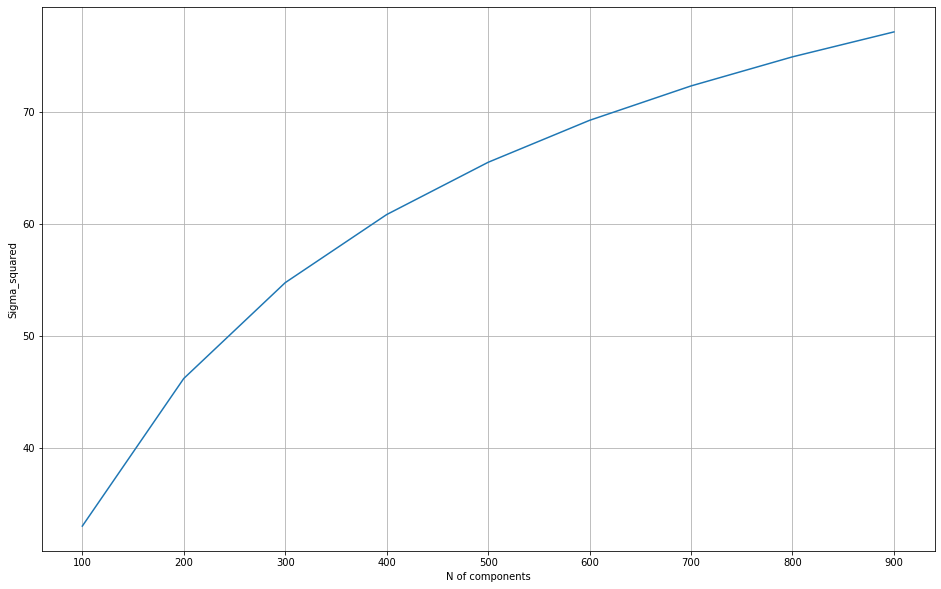

In [34]:
choosing_parameters(tfidf_wm, 100, 1000, 100)

Thus, we can see that 60% retainment of variance is reached with number of components being equal to roughly 370. 400 components will guarantee above 60 % retainment of variance because the plot takes into 100 components at each step. 

In [53]:
svd = TruncatedSVD(n_components=400, random_state=42) # this random seed will be used for further feature names
svd.fit(tfidf_wm)
#np.cumsum(svd.explained_variance_ratio_)
reduced = svd.transform(tfidf_wm)

We have to recover feature names corresponding to the words chosen by the truncated svd. Thus, we are using the same random seed and number of components. 

In [31]:
def feature_sample(tfidf_tokens, seed, n_components):
    np.random.seed(seed)
    tfidf_tokens_samples = np.random.choice(tfidf_tokens, size=n_components)
    tfidf_tokens_samples = sorted(tfidf_tokens_samples)
    return tfidf_tokens_samples

In [60]:
tfidf_tokens_samples = feature_sample(tfidf_tokens, 42, 400) 
tfidf_tokens_samples[:5]

['acid', 'adder', 'affectionate', 'afterglow', 'aid']

In [20]:
from scipy.sparse import csr_matrix

In [17]:
def matrix_creation(reduced, tfidf_tokens_samples):
    matrix = csr_matrix(reduced)
    matrix = matrix.todense()

    df = pd.DataFrame(matrix, columns = tfidf_tokens_samples)
    
    return df

In [67]:
df1 = matrix_creation(reduced, tfidf_tokens_samples)
df1.head(2)

,acid,adder,affectionate,afterglow,aid,aide,airiness,airtight,ala,alimentum,...,watering,whaler,whiskey,window,wish,wooden,wrapping,wroth,yellowfin,yest
0,0.053276,0.072860,0.285792,-0.268519,0.093437,0.093128,0.021991,0.119601,-0.015678,-0.045102,...,0.000796,-0.002724,-0.002611,-0.006119,-0.002040,0.000643,0.001911,0.004821,0.001673,-0.002350
1,0.002894,0.002751,0.004579,0.002166,0.000063,-0.006545,-0.003530,0.002741,-0.000744,0.004686,...,-0.005668,-0.006905,0.000268,-0.000423,0.002048,0.000254,-0.005901,-0.007431,0.004191,0.001035


In [68]:
df1.to_csv('words.csv', compression = 'gzip')

### Cluster implementation

In [21]:
from sklearn.cluster import KMeans
from sklearn import metrics 
from scipy.spatial.distance import cdist 

In [23]:
mapping1_dictionary = {} 
mapping2_dictionary = {} 
contortions_list = [] 
inertias_list = [] 
for k in range(1,11): 
    kmeanModel = KMeans(n_clusters=k).fit(reduced) # here we are choosing optimal number of clusters
    kmeanModel.fit(reduced)     
      
    contortions_list.append(sum(np.min(cdist(reduced, kmeanModel.cluster_centers_, 
                      'euclidean'),axis=1)) / reduced.shape[0]) 
    inertias_list.append(kmeanModel.inertia_) 
  
    mapping1_dictionary[k] = sum(np.min(cdist(reduced, kmeanModel.cluster_centers_, 
                 'euclidean'),axis=1)) / reduced.shape[0] 
    mapping2_dictionary[k] = kmeanModel.inertia_

In [25]:
plt.plot(range, contortions_list, 'bx-') 
plt.show()
# thus according to this plot, number of clusters is chosen to be 10

In [56]:
def model_building(reduced):
    model = KMeans(n_clusters = 10,init='k-means++', random_state=99)
    model.fit(reduced)
    labels = model.labels_
    return labels

In [57]:
labels = model_building(reduced)

In [106]:
#df.to_csv('data4.csv')
df = pd.read_csv('data4.csv')
df.drop(columns=['Unnamed: 0'], inplace = True)
df.head(2)

,id,pid,uid,score,ds,nouns,upd_nouns
0,1,B001E4KFG0,A3SGXH7AUHU8GW,5,2011-04-27,"[vitality, dog, food, quality, product, meat, ...","['vitality', 'dog', 'food', 'quality', 'meat']"
1,2,B00813GRG4,A1D87F6ZCVE5NK,1,2012-09-07,"[product, jumbo, error, vendor, represent, pro...","['jumbo', 'error', 'vendor', 'represent']"


In [107]:
df['cluster'] = labels
df['upd_nouns'] = df.upd_nouns.str.replace('[^a-zA-Z]', ' ')
#df[~df.upd_nouns.str.contains("XYZ")]
df.head(2)

,id,pid,uid,score,ds,nouns,upd_nouns,cluster
0,1,B001E4KFG0,A3SGXH7AUHU8GW,5,2011-04-27,"[vitality, dog, food, quality, product, meat, ...",vitality dog food quality meat,2
1,2,B00813GRG4,A1D87F6ZCVE5NK,1,2012-09-07,"[product, jumbo, error, vendor, represent, pro...",jumbo error vendor represent,6


In [108]:
df_cluster = df.groupby('cluster')['upd_nouns'].apply(lambda x: ' '.join(x)).reset_index()
df_cluster.cluster += 1
df_cluster

,cluster,upd_nouns
0,1,tea south tea tea purchase d...
1,2,satisfy trick quality store cand...
2,3,vitality dog food quality meat ...
3,4,scrape fact oatmeal brand oatmea...
4,5,coffee fan mother machine coffee...
5,6,confection pillowy case sugar ch...
6,7,jumbo error vendor represent in...
7,8,snack trail mix chocolate days ...
8,9,chocolate chip flour difference ...
9,10,deal salt family year problem ...


In [99]:
df.cluster.value_counts()

6    49914
0     4533
2     4228
4     3648
7     2674
3     2298
5     2143
1     2022
8     1402
9     1396
Name: cluster, dtype: int64

### Representation through WordCloud

In [109]:
from wordcloud import WordCloud

Thus, it seems there are ten seeming clusters: 
<br>
1) Tea
<br>
2) Quality, Product
<br>
3) Dog food 
<br>
4) Water, drinks?
<br>
5) coffee
<br>
6) sugar, syrup
<br>
7) bag, box
<br>
8) chocolate
<br>
9) protein
<br>
10) salt

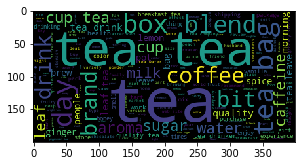

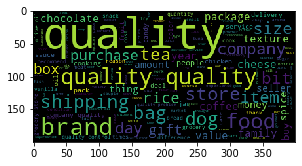

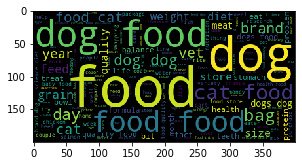

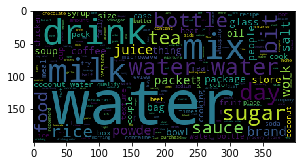

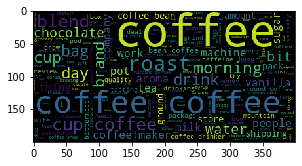

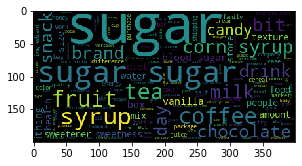

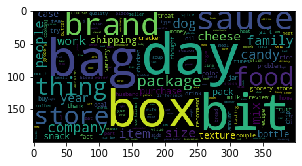

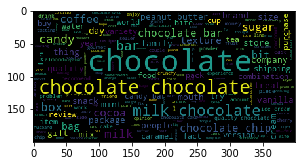

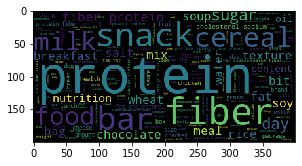

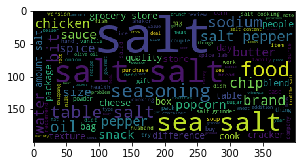

In [113]:
for i in range(len(df_cluster)):
    wordcloud = WordCloud().generate(df_cluster.iloc[i].upd_nouns) 
    plt.figure(figsize = (4,4)) 
    plt.imshow(wordcloud) 
    plt.tight_layout(pad = 0) 
    plt.show()

##### Below, number of unique users writing reviews in each cluster

In [111]:
df.groupby('cluster')['uid'].nunique()

cluster
0     3467
1     1727
2     3202
3     1939
4     3053
5     1835
6    38738
7     2285
8      997
9     1106
Name: uid, dtype: int64

## 3. Algorithmic Question

#### What is given:
You are given an array with A with n integer numbers.

Let s = min{ A[1], ..., A[n] } and b = max { A[1], ..., A[n] }.
Let r = (b - s),
Prove that we can sort A in time O(n + r).

My solution is to count number of occurences (x) of every element in array A. Afterwards, we have to put every element in order in final array x times. Thus, with N being equal to the length and K being equal to the number of distinct elements in A, the time complexity will be O(N+K).

In [116]:
from collections import defaultdict 

In [117]:
defaultdict(int)

defaultdict(int, {})

In [119]:
li=[15,12,10, 3]

minimum = 3 
maximum =15 

Range=maximum - minimum 

i=len(li)

In [120]:
def occurence_counting(li):
    count = defaultdict(int)
    for n in li:
        count[n] += 1
    return count
count =  occurence_counting(li)
j=len(count)

In [122]:
count, j

(defaultdict(int, {15: 1, 12: 1, 10: 1, 3: 1}), 4)

In [125]:
res = []
for j in range(minimum ,maximum+1):
    res = res+ [j]* count[j]
res

[3, 10, 12, 15]

As can be seen from above codes, the worst case scenario - the algorithm will take time O(N+N) times because numbers in A all can be distinct. When all the numbers are non-negative and distinct, the shortest time for the problem can be O(N+N-1) which is equal to O(N+N). 
<br>
Thus, it verifies that it is feasible to sort A in time O(N + R).